In [1]:
import torch
from tqdm import tqdm
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
torch.cuda.is_available()

False

In [3]:
# number of subprocesses to use for data loading

def get_loaders_2(batch_size=128, valid_size=0.3, num_workers=0):
    transform = transforms.ToTensor()# choose the training and testing datasets
    train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
    test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)# obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train)/2)
    train_index_1, train_index_2, valid_index = indices[:split], indices[split:split*2],indices[split*2:]# define samplers for obtaining training and validation batches
    train_sampler_1 = SubsetRandomSampler(train_index_1)
    train_sampler_2 = SubsetRandomSampler(train_index_2)
    valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
    train_loader_1 = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                               sampler = train_sampler_1, num_workers = num_workers)
    train_loader_2 = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                               sampler = train_sampler_2, num_workers = num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                              sampler = valid_sampler, num_workers = num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)
    return {"train":[train_loader_1, train_loader_2], "valid":valid_loader, "test":test_loader}



In [4]:
import torch.nn as nn
import torch.nn.functional as F# define NN architecture

class Net(nn.Module):
    def __init__(self, hidden_1=32):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc3 = nn.Linear(hidden_1,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x# initialize the NN

In [5]:

def train_model(model, train_loader, valid_loader, name="model"):
    #specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()# specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
    # number of epochs to train the model
    n_epochs = 10# initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity

    for epoch in range(n_epochs):
        # monitor losses
        train_loss = 0
        valid_loss = 0


        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data,label in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * data.size(0)


         ######################    
        # validate the model #
        ######################
        model.eval()  # prep model for evaluation
        for data,label in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # update running validation loss 
            valid_loss = loss.item() * data.size(0)

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        """
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
        """

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            #valid_loss_min,
            #valid_loss))
            torch.save(model.state_dict(), '%s.pt'%name)
            valid_loss_min = valid_loss

In [6]:
loaders = get_loaders_2()

In [11]:

for i in tqdm(range(15)):
    model = Net(32)
    train_model(model, loaders['train'][0], loaders['valid'], "models_a_%i"%(i+1))


for i in tqdm(range(5)):
    model = Net(32)
    train_model(model, loaders['train'][1], loaders['valid'], "models_b_%i"%(i+1))

100%|██████████| 5/5 [07:25<00:00, 89.07s/it]


In [7]:
test_loaders = loaders["test"]
list_models = []
for i in range(15):
    model_i = Net(32)
    model_i.load_state_dict(torch.load('models_a_%i.pt'%(i+1)))
    model_i.eval()
    list_models.append(model_i)

for i in range(5):
    model_i = Net(32)
    model_i.load_state_dict(torch.load('models_b_%i.pt'%(i+1)))
    model_i.eval()
    list_models.append(model_i)
    

In [8]:
# initialize lists to monitor test loss and accuracy
def eval_model(model, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1# calculate and print avg test loss

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [9]:
test_loader = loaders["test"]

In [10]:

for model in list_models:
    eval_model(model, test_loader)


Test Accuracy: 65% (6591/10000)

Test Accuracy: 68% (6860/10000)

Test Accuracy: 67% (6778/10000)

Test Accuracy: 67% (6725/10000)

Test Accuracy: 68% (6881/10000)

Test Accuracy: 66% (6660/10000)

Test Accuracy: 68% (6805/10000)

Test Accuracy: 68% (6870/10000)

Test Accuracy: 66% (6602/10000)

Test Accuracy: 68% (6807/10000)

Test Accuracy: 69% (6982/10000)

Test Accuracy: 67% (6702/10000)

Test Accuracy: 68% (6825/10000)

Test Accuracy: 69% (6922/10000)

Test Accuracy: 66% (6694/10000)

Test Accuracy: 67% (6748/10000)

Test Accuracy: 67% (6776/10000)

Test Accuracy: 67% (6794/10000)

Test Accuracy: 66% (6684/10000)

Test Accuracy: 65% (6580/10000)


In [17]:
def eval_rule(list_models, rule=np.sum):

    accuracy = 0
    total = 0
    
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = []
        for i, model in enumerate(list_models):
            output = model(data)
            outputs.append(output)
        for i in range(outputs[0].shape[0]):
            ratings = np.zeros((len(list_models), 10))
            for j in range(len(list_models)):
                proba = np.exp(outputs[j][i].detach().numpy())
                proba /= proba.sum()
                ratings[j] = proba
            total += 1
            if (rule(ratings,axis=0).argmax() == target.data[i].item()):
                accuracy += 1
                
    print(accuracy/total)
        
eval_rule(list_models, np.sum)
eval_rule(list_models, np.prod)

0.6784
0.6778


In [18]:
import embedded_voting as ev

def eval_rule_ev(list_models, rule=ev.FastNash()):
    aggregator = ev.Aggregator()
    accuracy = 0
    total = 0
    
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = []
        for i, model in enumerate(list_models):
            output = model(data)
            outputs.append(output)
        for i in range(outputs[0].shape[0]):
            ratings = np.zeros((len(list_models), 10))
            for j in range(len(list_models)):
                proba = np.exp(outputs[j][i].detach().numpy())
                proba /= proba.sum()
                ratings[j] = proba
            total += 1
            train = True
            if total > 100:
                train = False
            results = aggregator(ratings, train=train)
            if (results.winner_ == target.data[i].item()):
                accuracy += 1
                
    print(accuracy/total)
        
eval_rule_ev(list_models, ev.FastNash())

0.6766


In [11]:
def correlation(a,b,c,d):
    return (a*d-c*b)/np.sqrt((a+b)*(c+d)*(a+c)*(b+d))

def qStatistic(a,b,c,d):
    return (a*d-c*b)/(a*d+b*c)
    
def disagreement(a,b,c,d):
    return b+c

def doubleFault(a,b,c,d):
    return d

def computeMat(A,B,C, f):
    n = len(A)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            M[i,j] = f(A[i,j],B[i,j],B[j,i],C[i,j])
    return M

In [12]:
import embedded_voting as ev
import matplotlib.pyplot as plt


def matrix_dep(list_models):

    accuracy = 0
    total = 0
    n = len(list_models)
    matA = np.zeros((n,n))
    matB = np.zeros((n,n))
    matC = np.zeros((n,n))
    for data, target in tqdm(test_loader):
        # forward pass: compute predicted outputs by passing inputs to the model
        preds = []
        for i, model in enumerate(list_models):
            output = model(data)
            _, pred = torch.max(output, 1)
            preds.append(pred)
        for i in range(preds[0].shape[0]):
            res= target.data[i].item()
            ratings = np.zeros((len(list_models), 10))
            for j in range(len(list_models)):
                for j2 in range(j+1, len(list_models)):
                    if (preds[j][i] == res):
                        if (preds[j2][i] == res):
                            matA[j,j2] += 1
                        else:
                            matB[j,j2] += 1
                    else:
                        if (preds[j2][i] == res):
                            matB[j2,j] += 1
                        else:
                            matC[j,j2] += 1
            
            total += 1
            #if (total == 10):
                #print(aggregator.embeddings.n_sing_val_)
                #print(aggregator.embeddings)
                #return
                
    return matA, matB, matC

matA, matB, matC = matrix_dep(list_models)

100%|██████████| 79/79 [00:34<00:00,  2.30it/s]


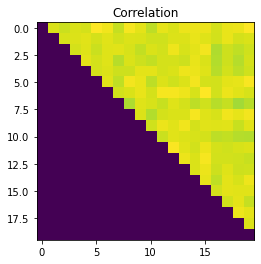

In [13]:
m1 = computeMat(matA, matB, matC, correlation)
plt.imshow(m1)
plt.title("Correlation")
plt.show()

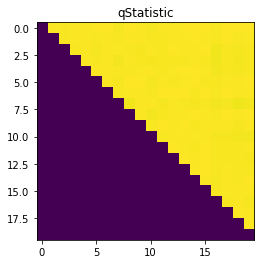

In [14]:
m1 = computeMat(matA, matB, matC, qStatistic)
plt.imshow(m1)
plt.title("qStatistic")
plt.show()

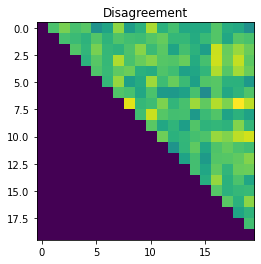

In [16]:
m1 = computeMat(matA, matB, matC, disagreement)
plt.imshow(m1)
plt.title("Disagreement")
plt.show()

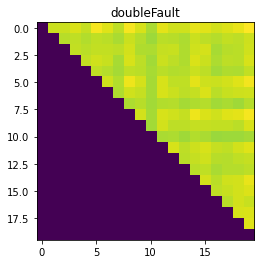

In [17]:
m1 = computeMat(matA, matB, matC, doubleFault)
plt.imshow(m1)
plt.title("doubleFault")
plt.show()

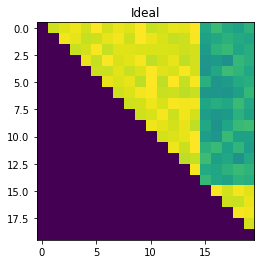

In [18]:
n = len(m1)
m = np.zeros((n,n))
g_size = [15,5]
for i in range(n):
    for j in range(i+1,n):
        m[i,j] = 0.5 + np.random.rand()*0.2
    
s = 0
for g in g_size:
    for i in range(s,s+g):
        for j in range(i+1,s+g):
            m[i,j] = 0.9 + np.random.rand()*0.1
    s += g
            
plt.imshow(m)
plt.title("Ideal")
plt.show()